Here, we attempt to try and replicate the results of <link> http://people.idsia.ch/~ciresan/data/miccai2013.pdf </link>.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cPickle as pickle
import os
import glob
import sys
import gzip

import numpy as np
import theano

import sklearn
import sknn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import csv
import xlrd
import codecs

In [2]:
# Constants
SIZE = 2084
PATCH_SIZE = 40
MAX_PATCH_SIZE = 120

VAL_NUM = 11
NUM = 2084*2084
VAL_PATCH_NUM = 144
split = 0.7
TRAIN = "train/A0";
TEST = "test/A0";
retrain = True

In [3]:
img = []
coords = []

cnt = 0
for imgfile in glob.iglob("train" + "/*.bmp"):
    print imgfile,
    annotfile = imgfile[:-3] + "csv"
    img.append(plt.imread(imgfile))
    csvReader = csv.reader(codecs.open(annotfile, 'rU', 'utf-8'))
    tot = 0
    imgMask = np.zeros((SIZE, SIZE));
    for row in csvReader:
        minx, miny, maxx, maxy = (SIZE, SIZE, 0, 0)
        for i in range(0, len(row)/2):
            tot = tot + 1
            xv, yv = (int(row[2*i]), int(row[2*i+1]))
            if xv > MAX_PATCH_SIZE/2 and yv > MAX_PATCH_SIZE/2 and xv < SIZE - MAX_PATCH_SIZE/2 and yv < SIZE - MAX_PATCH_SIZE/2:
                coords.append((yv, xv, cnt))
    cnt += 1
img = np.array(img)

print img.shape
print len(coords)

AttributeError: 'list' object has no attribute 'isspace'

In [4]:
print img.shape
print len(coords)
def get_patches(coords, patchsize = PATCH_SIZE):
    patches = np.zeros((len(coords), patchsize, patchsize, 3))
    i = 0
    for (x, y, img_num) in coords:
        patches[i] = img[img_num, (x - patchsize/2):(x + patchsize/2), (y - patchsize/2):(y + patchsize/2),:]
        patches[i] = np.divide(patches[i], 255.0)
        i += 1
    return patches

(35, 2084, 2084, 3)
128563


In [6]:
from skimage.transform import rotate

def variations(img_array, img_data):
    arr = []
    data = []
    for img, val in zip(img_array, img_data):
        for i in range(0,12):
            data.append(val)
        arr.append(img)
        arr.append(rotate(img, 90))
        arr.append(rotate(img, 180))
        arr.append(rotate(img, 270))
        arr.append(np.fliplr(img))
        arr.append(rotate(np.fliplr(img), 90))
        arr.append(rotate(np.fliplr(img), 180))
        arr.append(rotate(np.fliplr(img), 270))
        arr.append(np.flipud(img))
        arr.append(rotate(np.flipud(img), 90))
        arr.append(rotate(np.flipud(img), 180))
        arr.append(rotate(np.flipud(img), 270))
    return np.array(arr), np.array(data)

In [5]:
lookup = set(coords)

import random

def make_normal_set(length):
    norm_coords = []
    while len(norm_coords) < length:
        triple = (random.randint(MAX_PATCH_SIZE/2, SIZE - MAX_PATCH_SIZE/2 - 1), 
                     random.randint(MAX_PATCH_SIZE/2, SIZE - MAX_PATCH_SIZE/2 - 1),
                     random.randint(0, len(img) - 1))
        if triple not in lookup:
            norm_coords.append(triple)
    return norm_coords

In [6]:
trainImg = get_patches(coords + make_normal_set(len(coords)))
trainVal = np.append(np.ones(len(coords)), np.zeros(len(coords)))

print trainImg.shape
print trainVal

(257126, 40, 40, 3)
[ 1.  1.  1. ...,  0.  0.  0.]


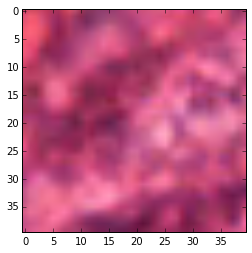

In [9]:
plt.imshow(random.choice(trainImg))

In [10]:
from sklearn.utils import shuffle
print "Shuffling Data"
trainImg2, trainVal2 = shuffle(trainImg, trainVal)

print "Shuffled Data, adding random percolations:"
#trainImg2, trainVal2 = variations(trainImg2, trainVal2)

Shuffling Data
Shuffled Data, adding random percolations:


In [ ]:
from sknn.mlp import Classifier, Layer, Convolution
from sklearn import cross_validation

trainImg2 = trainImg2.astype(np.float32)
trainVal2 = trainVal2.astype(np.uint8)

print trainImg.shape

print "Building Classifier:"
nn = Classifier(
    layers=[
        Convolution("Rectifier", channels=128, kernel_shape=(4,4), pool_shape = (2, 2)),
        Convolution("Rectifier", channels=192, kernel_shape=(4,4), pool_shape = (2, 2), dropout = 0.3),
        Convolution("Rectifier", channels=256, kernel_shape=(4,4), pool_shape = (2, 2), dropout = 0.3),
        Layer("Rectifier", units=312, dropout = 0.4),
        Layer("Softmax")],
    #weights=nn_old.weights,
    learning_rate=0.001, verbose = True,
    n_iter=30)

print "Training Classifier: 70/30 split"
X_train, X_test, y_train, y_test = cross_validation.train_test_split(trainImg2, trainVal2)
nn.fit(X_train, y_train)
score = nn.score(X_test, y_test)
print score

/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/Users/nikcheerla/src/lasagne/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


(257126, 40, 40, 3)
Building Classifier:
Training Classifier: 70/30 split
................................